In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define transform
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

full_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

from torch.utils.data import random_split

# Split into train and val
train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [309]:
import torch
import torchvision
class GEDReLU5Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, S_n_n, S_n_p, S_p_n, S_p_p, Gi, l, k1, k2, p = 1):
        ctx.l = l
        ctx.k1 = k1
        ctx.k2 = k2
        ctx.p = p
        ctx.save_for_backward(input, S_n_n, S_n_p, S_p_n, S_p_p, Gi)
        return F.relu(input)
    # @staticmethod
    # def forward(ctx, input):
    #     # ctx.l = l
    #     # ctx.k = k
    #     # ctx.p = p
    #     ctx.save_for_backward(input)
    #     return F.relu(input)

    @staticmethod
    def backward(ctx, grad_output):
        input, S_n_n, S_n_p, S_p_n, S_p_p, Gi = ctx.saved_tensors

        # print("---input shape:", input.shape)
        # print("S_n_n shape:", S_n_n.shape)
        # print("S_n_p shape:", S_n_p.shape)
        # print("S_p_n shape:", S_p_n.shape)
        # print("S_p_p shape:", S_p_p.shape)
        # print("grad_output shape:", grad_output.shape)


        l, k1, k2, p = ctx.l, ctx.k1, ctx.k2, ctx.p

        S_n_n = S_n_n.unsqueeze(0)  # [1, C, H, W]
        S_n_p = S_n_p.unsqueeze(0)
        S_p_n = S_p_n.unsqueeze(0)
        S_p_p = S_p_p.unsqueeze(0)
        Gi = Gi.unsqueeze(0)
        
        # Gradient mask and kernel
        relu_mask = (input > 0).float()
        kernel = torch.where(input*grad_output > 0,
            torch.zeros_like(input) if l*k1 == 0 else l / (1 + torch.abs(input) / (l * k1)),
            torch.zeros_like(input) if l*k2 == 0 else l / (1 + torch.abs(input) / (l * k2)),
        )

        # Modulated gradient through activation
        grad_input = relu_mask*grad_output
        eventual_input = - torch.sign(input) * kernel * grad_output

        eps = 1e-12
        # Apply gating logic
        gated_eventual_input = torch.where(
            input < 0,
            torch.where(
                (S_n_n + S_n_p <= 0) | (eventual_input <= 0),
                eventual_input,
                eventual_input * (-S_n_n / (S_n_p + eps))
            ),
            torch.where(
                (S_p_p + S_p_n >= 0) | (eventual_input >= 0),
                eventual_input,
                eventual_input * (S_p_p / (-S_p_n + eps))
            )
        )

        S_n = S_n_n + S_n_p
        S_n_c = S_n*(S_n < 0).float()
        S_p = S_p_p + S_p_n
        S_p_c = S_p*(S_p > 0).float()
        
        s = min(torch.sum(Gi*(S_n_c+ S_p_c))/(torch.sum(Gi*Gi)+ eps),0)
        
        gated_grad_input = grad_input *(1 - s)

        grad_S_n_n = (((input < 0) & (eventual_input < 0)).float() * eventual_input).sum(dim = 0)
        grad_S_n_p = (((input < 0) & (eventual_input > 0)).float() * eventual_input).sum(dim = 0)
        grad_S_p_n = (((input > 0) & (eventual_input < 0)).float() * eventual_input).sum(dim = 0)
        grad_S_p_p = (((input > 0) & (eventual_input > 0)).float() * eventual_input).sum(dim = 0)

        return gated_grad_input + gated_eventual_input*p, grad_S_n_n, grad_S_n_p, grad_S_p_n, grad_S_p_p, eventual_input, None, None, None, None


import torch
import torch.nn as nn
import torch.nn.functional as F

class GEDReLU5(nn.Module):
    def __init__(self, shape = None, l=0.01, k1=1, k2= 1.0, p=1.0):
        super().__init__()
        self.l = l
        self.k1 = k1
        self.k2 = k2
        self.p = p
        self.is_GED = True

        if shape != None:
            self.S_n_n = nn.Parameter(torch.zeros(shape), requires_grad=True)
            self.S_n_p = nn.Parameter(torch.zeros(shape), requires_grad=True)
            self.S_p_n = nn.Parameter(torch.zeros(shape), requires_grad=True)
            self.S_p_p = nn.Parameter(torch.zeros(shape), requires_grad=True)
            self.Gi = nn.Parameter(torch.zeros(shape), requires_grad=True)
            self.S_n_n.is_GED = True
            self.S_n_p.is_GED = True
            self.S_p_n.is_GED = True
            self.S_p_p.is_GED = True
            self.Gi.is_GED = True
        else:
            self.S_n_n = None
            

    def forward(self, input):
        # # Lazy init on first call
        if self.S_n_n is None:
            shape = input.shape[1:]  # Exclude batch dim
            device = input.device
            dtype = input.dtype
            self.S_n_n = nn.Parameter(torch.zeros(shape, device=device, dtype=dtype), requires_grad=True)
            self.S_n_p = nn.Parameter(torch.zeros(shape, device=device, dtype=dtype), requires_grad=True)
            self.S_p_n = nn.Parameter(torch.zeros(shape, device=device, dtype=dtype), requires_grad=True)
            self.S_p_p = nn.Parameter(torch.zeros(shape, device=device, dtype=dtype), requires_grad=True)
            self.Gi = nn.Parameter(torch.zeros(shape, device=device, dtype=dtype), requires_grad=True)
            self.S_n_n.is_GED = True
            self.S_n_p.is_GED = True
            self.S_p_n.is_GED = True
            self.S_p_p.is_GED = True
            self.Gi.is_GED = True
        return GEDReLU5Function.apply(input, self.S_n_n, self.S_n_p, self.S_p_n, self.S_p_p, self.Gi, self.l, self.k1, self.k2, self.p)
        # return GEDReLUFunction.apply(input)

    def update_s(self, beta=0.9):
        """
        Manual update rule, called every epoch.
        Implements EMA-like update:
        S := beta * S + (1 - beta) * grad_S
        """
        for param in [self.S_n_n, self.S_n_p, self.S_p_n, self.S_p_p, self.Gi]:
            if param.grad is not None:
                param.data.mul_(beta).add_((1 - beta) * param.grad.data)
                param.grad.detach_()
                param.grad.zero_()

    def get_s_buffers(self):
        return {
            "S_n_n": self.S_n_n,
            "S_n_p": self.S_n_p,
            "S_p_n": self.S_p_n,
            "S_p_p": self.S_p_p
        }

In [342]:
import torch
import torchvision
class GEDGELUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, S_n_n, S_n_p, Gi, l, k1, k2, p = 1):
        ctx.l = l
        ctx.k1 = k1 
        ctx.k2 = k2
        ctx.p = p
        ctx.save_for_backward(input, S_n_n, S_n_p, Gi)
        return F.gelu(input)
    # @staticmethod
    # def forward(ctx, input):
    #     # ctx.l = l
    #     # ctx.k = k
    #     # ctx.p = p
    #     ctx.save_for_backward(input)
    #     return F.relu(input)

    @staticmethod
    def backward(ctx, grad_output):
        input, S_n_n, S_n_p, Gi = ctx.saved_tensors

        # print("---input shape:", input.shape)
        # print("S_n_n shape:", S_n_n.shape)
        # print("S_n_p shape:", S_n_p.shape)
        # print("S_p_n shape:", S_p_n.shape)
        # print("S_p_p shape:", S_p_p.shape)
        # print("grad_output shape:", grad_output.shape)


        l, k1, k2, p = ctx.l, ctx.k1, ctx.k2, ctx.p

        S_n_n = S_n_n.unsqueeze(0)  # [1, C, H, W]
        S_n_p = S_n_p.unsqueeze(0)
        Gi = Gi.unsqueeze(0)
        
        # Gradient mask and kernel
        gelu_mask = 0.5*(torch.erf(input/np.sqrt(2))+1) + input/np.sqrt(2*np.pi)*torch.exp(-input*input/2)
        v = 0.6
        kernel = torch.where(input*grad_output > 0,
            torch.zeros_like(input) if l*k1 == 0 else l*v*input / (1 + torch.abs(input*input*v*v) / (k1)),
            torch.zeros_like(input) if l*k2 == 0 else l*v*input / (1 + torch.abs(input*input*v*v) / (k2)),
        )

        # Modulated gradient through activation
        grad_input = gelu_mask*grad_output
        eventual_input = (input < 0).float() * kernel * grad_output

        eps = 1e-12
        # Apply gating logic
        gated_eventual_input = torch.where((eventual_input <= 0)| (S_n_n + S_n_p <= 0),
                    eventual_input,
                    eventual_input * (-S_n_n / (S_n_p + eps)),
                )

        S_n = S_n_n + S_n_p
        S_n_c = S_n*(S_n< 0).float()
        s = min(torch.sum(Gi*S_n_c)/(torch.sum(Gi*Gi)+ eps),0)
        
        gated_grad_input = grad_input *(1 - s)
        # gated_grad_input = grad_input *( 1 + torch.where((S_n_n + S_n_p < 0) & (Gi > 0), -(S_n_n + S_n_p)/Gi, 0))

        grad_S_n_n = (((input < 0) & (eventual_input < 0)).float() * eventual_input).sum(dim = 0)
        grad_S_n_p = (((input < 0) & (eventual_input > 0)).float() * eventual_input).sum(dim = 0)

        return gated_grad_input + gated_eventual_input, grad_S_n_n, grad_S_n_p, grad_input , None, None, None, None, None


import torch
import torch.nn as nn
import torch.nn.functional as F

class GEDGELU(nn.Module):
    def __init__(self, shape = None, l=0.01, k1=1, k2 = 1, p=1.0):
        super().__init__()
        self.l = l
        self.k1 = k1
        self.k2 = k2
        self.p = p
        self.is_GED = True

        if shape != None:
            self.S_n_n = nn.Parameter(torch.zeros(shape), requires_grad=True)
            self.S_n_p = nn.Parameter(torch.zeros(shape), requires_grad=True)
            self.Gi = nn.Parameter(torch.zeros(shape), requires_grad=True)
            self.S_n_n.is_GED = True
            self.S_n_p.is_GED = True
            self.Gi.is_GED = True
        else:
            self.S_n_n = None
            

    def forward(self, input):
        # # Lazy init on first call
        if self.S_n_n is None:
            shape = input.shape[1:]  # Exclude batch dim
            device = input.device
            dtype = input.dtype
            self.S_n_n = nn.Parameter(torch.zeros(shape, device=device, dtype=dtype), requires_grad=True)
            self.S_n_p = nn.Parameter(torch.zeros(shape, device=device, dtype=dtype), requires_grad=True)
            self.Gi = nn.Parameter(torch.zeros(shape, device=device, dtype=dtype), requires_grad=True)
            self.S_n_n.is_GED = True
            self.S_n_p.is_GED = True
            self.Gi.is_GED = True
        return GEDGELUFunction.apply(input, self.S_n_n, self.S_n_p, self.Gi, self.l, self.k1, self.k2, self.p)
        # return GEDReLUFunction.apply(input)

    def update_s(self, beta=0.9):
        """
        Manual update rule, called every epoch.
        Implements EMA-like update:
        S := beta * S + (1 - beta) * grad_S
        """
        for param in [self.S_n_n, self.S_n_p, self.Gi]:
            if param.grad is not None:
                param.data.mul_(beta).add_((1 - beta) * param.grad.data)
                param.grad.detach_()
                param.grad.zero_()

    def get_s_buffers(self):
        return {
            "S_n_n": self.S_n_n,
            "S_n_p": self.S_n_p,
            "S_p_n": self.S_p_n,
            "S_p_p": self.S_p_p
        }

In [166]:
a = torch.tensor([1,1])
b = torch.tensor([-1,-1])
#increase magnitude of a by magnitude of b projected onto a
s =  min(torch.sum(a*b)/torch.sum(a*a),0)
ae = a*( 1-s)
ae

tensor([2., 2.])

In [178]:
torch.cmin(torch.rand([10,10]),0)

AttributeError: module 'torch' has no attribute 'cmin'

In [153]:
torch.tensordot(a,b)

RuntimeError: tensordot expects dims < ndim_a or ndim_b, but got dims=2

In [ ]:
torch.tensordot(a,a)

In [299]:
class GEDCNN(nn.Module):
    def __init__(self, l=0.01, k1=5.0, k2 = 1.0, act_class = GEDReLU,):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = act_class( l=l, k1=k1, k2=k2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = act_class( l=l, k1=k1, k2=k2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = act_class( l=l, k1=k1, k2=k2)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.relu4 = act_class( l=l, k1=k1, k2=k2)

        self.fc2 = nn.Linear(128, 10)  # Output layerv
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in [self.fc2]:
            nn.init.kaiming_uniform_(m.weight, nonlinearity='linear')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        for m in [self.conv1,self.conv2,self.conv3,self.fc1]:
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        

    def update_s(self,beta = 0.99):
        for module in self.children():
            if hasattr(module,"is_GED"):
                module.update_s(beta)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = self.pool(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [343]:
class GEDGELUCNN(nn.Module):
    def __init__(self, l=0.01, k1=5.0, k2 = 1.0):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = GEDGELU( l=l, k1=k1, k2=k2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = GEDGELU( l=l, k1=k1, k2=k2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = GEDGELU( l=l, k1=k1, k2=k2)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.relu4 = GEDGELU( l=l, k1=k1, k2=k2)

        self.fc2 = nn.Linear(128, 10)  # Output layerv
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in [self.fc2]:
            nn.init.kaiming_uniform_(m.weight, nonlinearity='linear')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        for m in [self.conv1,self.conv2,self.conv3,self.fc1]:
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        

    def update_s(self,beta = 0.99):
        for module in self.children():
            if hasattr(module,"is_GED"):
                module.update_s(beta)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = self.pool(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [169]:
class CNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super().__init__()
        self.activation = activation_fn

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in [self.fc2]:
            nn.init.kaiming_uniform_(m.weight, nonlinearity='linear')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        for m in [self.conv1,self.conv2,self.conv3,self.fc1]:
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

    def update_s(self,beta = 0.99):
        pass

In [8]:
from tqdm import tqdm
from collections import defaultdict, deque

In [9]:
from Train import train_and_evaluate, validate_model

In [10]:
def train_and_evaluate_ged(network, train_loader, val_loader, epochs=10, lr=0.001,beta = 0.99, log_every=100, device='cpu',
                       save_path = None, save_every = 5, use_ged = True,
                       logger = None):
    model = network.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: not hasattr(p,"is_GED"), model.parameters()), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    logs = defaultdict(list)
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        grad_norms = []
        weight_updates = []
        
        running_loss = deque(maxlen=50)  # For smooth display
        running_acc = deque(maxlen=50)
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
        
            # Gradients and updates
            total_norm = 0
            weight_update_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
                    weight_update_norm += (lr * p.grad.data).norm(2).item() ** 2
        
            grad_norms.append(np.sqrt(total_norm))
            weight_updates.append(np.sqrt(weight_update_norm))
        
            optimizer.step()
            if use_ged:
                model.update_s(beta)
        
            batch_size = inputs.size(0)
            total_loss += loss.item() * batch_size
            total += batch_size
        
            batch_acc = (outputs.argmax(1) == labels).float().mean().item()
            correct += (outputs.argmax(1) == labels).sum().item()
        
            # if batch_idx % log_every == 0:
            #     logs['batches'].append({
            #         'epoch': epoch,
            #         'batch_idx': batch_idx,
            #         'loss': loss.item(),
            #         'acc': batch_acc,
            #         'grad_norm': grad_norms[-1],
            #         'weight_update_norm': weight_updates[-1],
            #         'samples_seen': total
            #     })
        
            # Track running stats for display
            running_loss.append(loss.item())
            running_acc.append(batch_acc)
        
            if batch_idx % 10 == 0:
                pbar.set_postfix({
                    'loss': f'{np.mean(running_loss):.4f}',
                    'acc': f'{np.mean(running_acc) * 100:.2f}%',
                    'grad_norm': f'{grad_norms[-1]:.2f}'
                })

        logs['train_loss'].append(total_loss / total)
        logs['train_acc'].append(correct / total)
        logs['train_grad_norm'].append(np.mean(grad_norms))
        logs['train_weight_update_norm'].append(np.mean(weight_updates))
        
        val_loss, val_acc = validate_model(model,val_loader,device)
        
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)
    
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {logs['train_loss'][-1]:.4f} | "
              f"Train Acc: {logs['train_acc'][-1]*100:.2f}% | "
              f"Val Acc: {logs['val_acc'][-1]*100:.2f}%")
    return logs, model

In [19]:
log_data = dict()
model_data = dict()
def insert_log_data(key,data):
    if key not in log_data:
        log_data[key] = []
    log_data[key].append(data)
def insert_model_data(key,data):
    if key not in log_data:
        model_data[key] = []
    model_data[key].append(data)

In [12]:

import GEDResNet
importlib.reload(GEDResNet)
from GEDResNet import GEDResNet18, initialize_ged_resnet

NameError: name 'importlib' is not defined

In [212]:
#Test clipped gmodrelu
import GModReLU
import importlib
importlib.reload(GModReLU)
from GModReLU import GModReLU, GModReLUFunction
loaded_model = CNN(GModReLU(l = l_val, k = k_val, kernel_type = ["nonscale","clip"]))
loaded_model.load_state_dict(torch.load('cnn_untrained1.pt', weights_only=True, map_location=torch.device('cpu')))
l_val = 0.02
k_val = 5.0
log, model = train_and_evaluate_ged(
    network = loaded_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=25,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("gmrelu(nonscale,clip)",l_val,k_val),log)

Epoch 1/25 | Train Loss: 1.6044 | Train Acc: 42.55% | Val Acc: 49.08%


Epoch 2/25 | Train Loss: 1.1996 | Train Acc: 57.17% | Val Acc: 56.98%


Epoch 3/25 | Train Loss: 1.0480 | Train Acc: 63.18% | Val Acc: 65.78%


Epoch 4/25 | Train Loss: 0.9478 | Train Acc: 66.85% | Val Acc: 65.72%


Epoch 5/25 | Train Loss: 0.8754 | Train Acc: 69.46% | Val Acc: 68.46%


Epoch 6/25 | Train Loss: 0.8212 | Train Acc: 71.33% | Val Acc: 71.12%


Epoch 7/25 | Train Loss: 0.7745 | Train Acc: 73.13% | Val Acc: 70.56%


Epoch 8/25 | Train Loss: 0.7401 | Train Acc: 74.13% | Val Acc: 74.26%


Epoch 9/25 | Train Loss: 0.7099 | Train Acc: 75.47% | Val Acc: 73.32%


Epoch 10/25 | Train Loss: 0.6796 | Train Acc: 76.56% | Val Acc: 73.70%


Epoch 11/25 | Train Loss: 0.6568 | Train Acc: 77.11% | Val Acc: 75.34%


Epoch 12/25 | Train Loss: 0.6431 | Train Acc: 77.47% | Val Acc: 75.96%


Epoch 13/25 | Train Loss: 0.6176 | Train Acc: 78.52% | Val Acc: 75.92%


Epoch 14/25 | Train Loss: 0.6019 | Train Acc: 79.19% | Val Acc: 76.40%


Epoch 15/25 | Train Loss: 0.5923 | Train Acc: 79.31% | Val Acc: 77.14%


Epoch 16/25 | Train Loss: 0.5715 | Train Acc: 80.12% | Val Acc: 77.46%


Epoch 17/25 | Train Loss: 0.5594 | Train Acc: 80.54% | Val Acc: 76.88%


Epoch 18/25 | Train Loss: 0.5553 | Train Acc: 80.48% | Val Acc: 77.48%


Epoch 19/25 | Train Loss: 0.5361 | Train Acc: 81.30% | Val Acc: 78.50%


Epoch 20/25 | Train Loss: 0.5296 | Train Acc: 81.54% | Val Acc: 77.82%


Epoch 21/25 | Train Loss: 0.5120 | Train Acc: 82.06% | Val Acc: 78.00%


Epoch 22/25 | Train Loss: 0.5044 | Train Acc: 82.43% | Val Acc: 78.04%


Epoch 23/25 | Train Loss: 0.5003 | Train Acc: 82.49% | Val Acc: 78.48%


Epoch 24/25 | Train Loss: 0.4890 | Train Acc: 82.90% | Val Acc: 78.18%


Epoch 25/25 | Train Loss: 0.4789 | Train Acc: 83.18% | Val Acc: 77.62%


In [317]:
#Testting new clipped dged
l_val = 0.02
k1_val = 7.5
k2_val = 0.5
loaded_model = GEDCNN(l = l_val, k1 = k1_val, k2 = k2_val)
loaded_model.load_state_dict(torch.load('cnn_untrained1.pt', weights_only=True, map_location=torch.device('cpu')))
log, model = train_and_evaluate_ged(
    network = loaded_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("ged4",l_val,k1_val,k2_val),log)

Epoch 1/10 | Train Loss: 1.5697 | Train Acc: 43.82% | Val Acc: 52.88%


Epoch 2/10 | Train Loss: 1.1664 | Train Acc: 58.77% | Val Acc: 61.08%


Epoch 3/10 | Train Loss: 1.0040 | Train Acc: 64.60% | Val Acc: 65.22%


Epoch 4/10 | Train Loss: 0.8979 | Train Acc: 68.73% | Val Acc: 68.50%


Epoch 5/10 | Train Loss: 0.8308 | Train Acc: 71.03% | Val Acc: 69.40%


Epoch 6/10 | Train Loss: 0.7761 | Train Acc: 72.93% | Val Acc: 73.54%


Epoch 7/10 | Train Loss: 0.7310 | Train Acc: 74.39% | Val Acc: 73.18%


Epoch 8/10 | Train Loss: 0.6951 | Train Acc: 75.83% | Val Acc: 75.70%


Epoch 9/10 | Train Loss: 0.6742 | Train Acc: 76.51% | Val Acc: 74.08%


Epoch 10/10 | Train Loss: 0.6400 | Train Acc: 77.67% | Val Acc: 76.08%


In [311]:
#Testting GED5
#Conclusion: Not significantly better
l_val = 0.02
k1_val = 7.5
k2_val = 0.5
loaded_model = GEDCNN(l = l_val, k1 = k1_val, k2 = k2_val, act_class = GEDReLU5)
loaded_model.load_state_dict(torch.load('cnn_untrained1.pt', weights_only=True, map_location=torch.device('cpu')))
log, model = train_and_evaluate_ged(
    network = loaded_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=11,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("ged5",l_val,k1_val,k2_val),log)

Epoch 1/11 | Train Loss: 1.5426 | Train Acc: 44.56% | Val Acc: 54.32%


Epoch 2/11 | Train Loss: 1.1422 | Train Acc: 59.39% | Val Acc: 62.28%


Epoch 3/11 | Train Loss: 0.9908 | Train Acc: 65.09% | Val Acc: 66.06%


Epoch 4/11 | Train Loss: 0.8910 | Train Acc: 68.78% | Val Acc: 69.40%


Epoch 5/11 | Train Loss: 0.8207 | Train Acc: 71.20% | Val Acc: 68.84%


Epoch 6/11 | Train Loss: 0.7730 | Train Acc: 72.93% | Val Acc: 71.88%


Epoch 7/11 | Train Loss: 0.7318 | Train Acc: 74.42% | Val Acc: 73.64%


Epoch 8/11 | Train Loss: 0.6935 | Train Acc: 75.62% | Val Acc: 72.40%


Epoch 9/11 | Train Loss: 0.6647 | Train Acc: 76.88% | Val Acc: 74.48%


Epoch 10/11 | Train Loss: 0.6408 | Train Acc: 77.62% | Val Acc: 74.82%


Epoch 11/11 | Train Loss: 0.6206 | Train Acc: 78.21% | Val Acc: 77.10%


In [ ]:
#Testting new clipped dged GELU with new kernel
l_val = 0.02
k1_val = 7.5
k2_val = 0.1
loaded_model = GEDGELUCNN(l = l_val, k1 = k1_val, k2 = k2_val)
loaded_model.load_state_dict(torch.load('cnn_untrained1.pt', weights_only=True, map_location=torch.device('cpu')))
log, model = train_and_evaluate_ged(
    network = loaded_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=7,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("gedgelu(ker3)",l_val,k1_val,k2_val),log)

Epoch 1/7:   8%|▊         | 55/704 [00:21<03:05,  3.50it/s, loss=2.2967, acc=22.59%, grad_norm=3.67] 

In [320]:
log_data[('ged4', 0.02, 7.5, 0.1)][1]['train_loss']

[1.4848653153101603,
 1.0595959030363296,
 0.9035886674775018,
 0.8083200914700825,
 0.7512857806735569,
 0.7062555783238675,
 0.6603865298165216,
 0.636535771730211,
 0.6080090568860372,
 0.5905408076816135,
 0.5694922658390469,
 0.5512248729652829,
 0.5357832288821538,
 0.5198717035690943,
 0.5023744517220391,
 0.4949553271823459,
 0.4873157972070906,
 0.4778727073113124,
 0.4646957883516947,
 0.4595615298377143,
 0.4511569716135661,
 0.44614050909678143,
 0.4364197584470113,
 0.4325642474386427,
 0.4244985025617811]

In [193]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('cnn_untrained1.pt', weights_only=True, map_location=torch.device('cpu')))
log, model = train_and_evaluate_ged(
    network = loaded_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=25,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("relu",),log)

Epoch 1/25 | Train Loss: 1.5801 | Train Acc: 43.58% | Val Acc: 51.52%


Epoch 2/25 | Train Loss: 1.2040 | Train Acc: 56.97% | Val Acc: 58.72%


Epoch 3/25 | Train Loss: 1.0430 | Train Acc: 63.01% | Val Acc: 63.94%


Epoch 4/25 | Train Loss: 0.9478 | Train Acc: 66.89% | Val Acc: 68.22%


Epoch 5/25 | Train Loss: 0.8820 | Train Acc: 69.12% | Val Acc: 68.16%


Epoch 6/25 | Train Loss: 0.8245 | Train Acc: 71.15% | Val Acc: 69.54%


Epoch 7/25 | Train Loss: 0.7818 | Train Acc: 72.77% | Val Acc: 71.22%


Epoch 8/25 | Train Loss: 0.7408 | Train Acc: 73.97% | Val Acc: 70.56%


Epoch 9/25 | Train Loss: 0.7260 | Train Acc: 74.71% | Val Acc: 73.52%


Epoch 10/25 | Train Loss: 0.6964 | Train Acc: 75.87% | Val Acc: 74.34%


Epoch 11/25 | Train Loss: 0.6773 | Train Acc: 76.35% | Val Acc: 75.22%


Epoch 12/25 | Train Loss: 0.6525 | Train Acc: 77.41% | Val Acc: 75.80%


Epoch 13/25 | Train Loss: 0.6334 | Train Acc: 77.96% | Val Acc: 74.74%


Epoch 14/25 | Train Loss: 0.6165 | Train Acc: 78.58% | Val Acc: 74.78%


Epoch 15/25 | Train Loss: 0.6027 | Train Acc: 78.91% | Val Acc: 75.52%


Epoch 16/25 | Train Loss: 0.5918 | Train Acc: 79.34% | Val Acc: 76.44%


Epoch 17/25 | Train Loss: 0.5805 | Train Acc: 79.68% | Val Acc: 77.08%


Epoch 18/25 | Train Loss: 0.5655 | Train Acc: 80.23% | Val Acc: 77.96%


Epoch 19/25 | Train Loss: 0.5549 | Train Acc: 80.75% | Val Acc: 77.90%


Epoch 20/25 | Train Loss: 0.5534 | Train Acc: 80.61% | Val Acc: 77.82%


Epoch 21/25 | Train Loss: 0.5391 | Train Acc: 81.28% | Val Acc: 78.52%


Epoch 22/25 | Train Loss: 0.5293 | Train Acc: 81.52% | Val Acc: 78.88%


Epoch 23/25 | Train Loss: 0.5224 | Train Acc: 81.76% | Val Acc: 77.66%


Epoch 24/25 | Train Loss: 0.5161 | Train Acc: 82.21% | Val Acc: 78.50%


Epoch 25/25 | Train Loss: 0.5088 | Train Acc: 82.23% | Val Acc: 79.36%


In [220]:
loaded_model = CNN(torch.nn.GELU())
loaded_model.load_state_dict(torch.load('cnn_untrained1.pt', weights_only=True, map_location=torch.device('cpu')))
log, model = train_and_evaluate_ged(
    network = loaded_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=25,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("gelu",),log)

Epoch 1/25 | Train Loss: 1.5255 | Train Acc: 45.46% | Val Acc: 56.12%


Epoch 2/25 | Train Loss: 1.1173 | Train Acc: 60.34% | Val Acc: 58.08%


Epoch 3/25 | Train Loss: 0.9623 | Train Acc: 65.89% | Val Acc: 68.10%


Epoch 4/25 | Train Loss: 0.8570 | Train Acc: 69.96% | Val Acc: 69.74%


Epoch 5/25 | Train Loss: 0.7964 | Train Acc: 71.95% | Val Acc: 71.86%


Epoch 6/25 | Train Loss: 0.7401 | Train Acc: 74.11% | Val Acc: 72.94%


Epoch 7/25 | Train Loss: 0.7033 | Train Acc: 75.38% | Val Acc: 73.16%


Epoch 8/25 | Train Loss: 0.6707 | Train Acc: 76.53% | Val Acc: 74.54%


Epoch 9/25 | Train Loss: 0.6398 | Train Acc: 77.68% | Val Acc: 75.30%


Epoch 10/25 | Train Loss: 0.6161 | Train Acc: 78.47% | Val Acc: 75.80%


Epoch 11/25 | Train Loss: 0.5971 | Train Acc: 79.02% | Val Acc: 76.32%


Epoch 12/25 | Train Loss: 0.5782 | Train Acc: 79.72% | Val Acc: 77.12%


Epoch 13/25 | Train Loss: 0.5629 | Train Acc: 80.35% | Val Acc: 77.10%


Epoch 14/25 | Train Loss: 0.5511 | Train Acc: 80.73% | Val Acc: 77.30%


Epoch 15/25 | Train Loss: 0.5269 | Train Acc: 81.54% | Val Acc: 77.90%


Epoch 16/25 | Train Loss: 0.5115 | Train Acc: 82.08% | Val Acc: 78.84%


Epoch 17/25 | Train Loss: 0.5055 | Train Acc: 82.18% | Val Acc: 78.14%


Epoch 18/25 | Train Loss: 0.4950 | Train Acc: 82.62% | Val Acc: 78.24%


Epoch 19/25 | Train Loss: 0.4895 | Train Acc: 82.76% | Val Acc: 78.88%


Epoch 20/25 | Train Loss: 0.4755 | Train Acc: 83.17% | Val Acc: 78.28%


Epoch 21/25 | Train Loss: 0.4653 | Train Acc: 83.69% | Val Acc: 79.72%


Epoch 22/25 | Train Loss: 0.4523 | Train Acc: 84.08% | Val Acc: 78.72%


Epoch 23/25 | Train Loss: 0.4431 | Train Acc: 84.46% | Val Acc: 78.52%


Epoch 24/25 | Train Loss: 0.4388 | Train Acc: 84.52% | Val Acc: 79.26%


Epoch 25/25 | Train Loss: 0.4330 | Train Acc: 84.84% | Val Acc: 79.06%


In [20]:
torch.save(CNN().state_dict(), "cnn_untrained1.pt")

In [75]:
l_val = 0.02
k1_val = 1.0
k2_val = 0.05
loaded_model = GEDCNN(l = l_val, k1 = k1_val, k2 = k2_val)
loaded_model.load_state_dict(torch.load('cnn_pretrained.pt', weights_only=True, map_location=torch.device('cpu')))
log, model = train_and_evaluate_ged(
    network = loaded_model,
    beta = 0.9,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("[pt]dged(0.9)",l_val,k1_val,k2_val),log)

Epoch 1/10 | Train Loss: 0.4478 | Train Acc: 84.58% | Val Acc: 84.44%


KeyboardInterrupt: 

In [190]:
#Testing on pretrained to 35 epochs (focusing in on a particular training regime)
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('cnn_pretrained.pt', weights_only=True, map_location=torch.device('cpu')))
log, model = train_and_evaluate_ged(
    network = loaded_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=6,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("[pt]relu",),log)

Epoch 1/6 | Train Loss: 0.4429 | Train Acc: 84.50% | Val Acc: 84.06%


Epoch 2/6 | Train Loss: 0.4382 | Train Acc: 84.72% | Val Acc: 84.44%


Epoch 3/6 | Train Loss: 0.4305 | Train Acc: 84.87% | Val Acc: 83.84%


Epoch 4/6 | Train Loss: 0.4176 | Train Acc: 85.37% | Val Acc: 84.28%


Epoch 5/6 | Train Loss: 0.4267 | Train Acc: 85.15% | Val Acc: 83.88%


Epoch 6/6 | Train Loss: 0.4129 | Train Acc: 85.48% | Val Acc: 83.48%


In [191]:
#Testing GED on pretrained to 35 epochs (focusing in on a particular training regime)
l_val = 0.02
k1_val = 1.0
k2_val = 0.0
loaded_model = GEDCNN(l = l_val, k1 = k1_val, k2 = k2_val)
loaded_model.load_state_dict(torch.load('cnn_pretrained.pt', weights_only=True, map_location=torch.device('cpu')))
log, model = train_and_evaluate_ged(
    network = loaded_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=35,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("[pt]bged",l_val,k_val),log)

Epoch 1/35 | Train Loss: 0.4446 | Train Acc: 84.61% | Val Acc: 83.06%


Epoch 2/35 | Train Loss: 0.4368 | Train Acc: 84.80% | Val Acc: 85.22%


Epoch 3/35 | Train Loss: 0.4320 | Train Acc: 84.89% | Val Acc: 84.12%


Epoch 4/35 | Train Loss: 0.4225 | Train Acc: 85.26% | Val Acc: 84.24%


Epoch 5/35 | Train Loss: 0.4145 | Train Acc: 85.57% | Val Acc: 84.58%


Epoch 6/35 | Train Loss: 0.4151 | Train Acc: 85.55% | Val Acc: 82.44%


Epoch 7/35 | Train Loss: 0.4108 | Train Acc: 85.57% | Val Acc: 84.28%


KeyboardInterrupt: 

In [370]:
torch.mean(model.relu1.S_n_p)

tensor(3.1503e-07, grad_fn=<MeanBackward0>)

In [278]:
#Test GEDResNet
l_val = 0.01
k_val = 1.0
log, model = train_and_evaluate_ged(
    network = GEDResNet18().apply(initialize_ged_resnet),
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=15,          # or however many you want
    lr=0.001,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
insert_log_data(("[resnet]ged",l_val,k_val),log)

KeyboardInterrupt: 

In [112]:
for i in range(10):
    l_val = 0.01
    k_val = 5.0
    log, model = train_and_evaluate_ged(
        network = GEDCNN(l = l_val, k = k_val),
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=2,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    insert_log_data(("ged",l_val,k_val),log)

KeyboardInterrupt: 

In [338]:
log_data[('gedgelu', 0.02, 7.5, 0.1)] = [log_data[('ged4', 0.02, 7.5, 0.1)][1]]

loss shape: (6,)
loss shape: (25,)
loss shape: (25,)
loss shape: (11,)
loss shape: (7,)
loss shape: (25,)


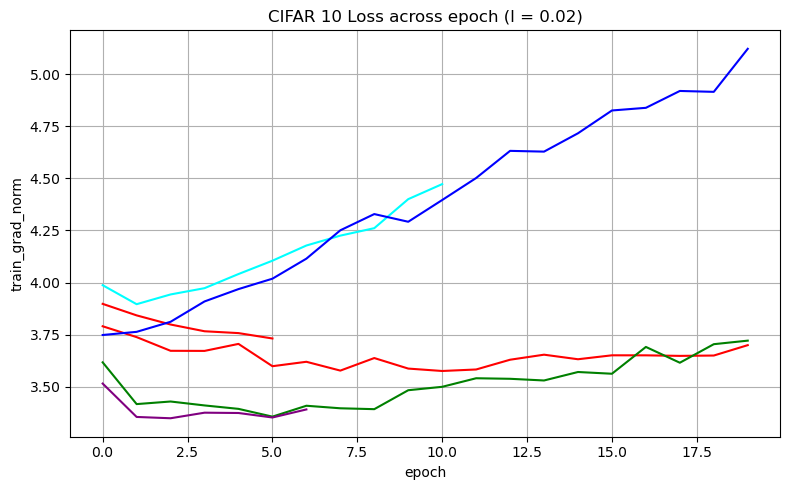

In [341]:
import importlib
import Figures
importlib.reload(Figures)
from Figures import log_data_with_k, plot_logs_k, plot_logs_ke, log_data_with_l , plot_logs_k_col, log_data_with_activations
prop = "train_grad_norm"
plot_logs_k_col(*log_data_with_activations([('relu',),('ged5', 0.02, 7.5, 0.5),("gelu",),('gedgelu', 0.02, 7.5, 0.1), ('gedgelu(ker2)', 0.02, 7.5, 0.1)],
                                           ["red","cyan","green","blue","purple","orange","yellow"], log_data),
                file_name = None,prop = prop, x_axis = 'epoch',i_cut = 10, e_range = (0,20), y_scale = "linear")
# plot_logs_k_col(*log_data_with_activations([('relu',),('ged4', 0.02, 1.0, 0.0),('ged4', 0.02, 5.0, 0.1), ('gmrelu(nonscale,clip)', 0.02, 5.0),("gelu",),('ged4', 0.02, 7.5, 0.1)],
#                                            ["red","cyan","green","blue","purple","orange","yellow"], log_data),
#                 file_name = None,prop = prop, x_axis = 'epoch',i_cut = 10, e_range = (5,25), y_scale = "linear")
# plot_logs_k_col(*log_data_with_activations([('relu',),('gmrelu(nonscale,clip)', 0.02, 1.0),('gmrelu(nonscale)', 0.02, 1.0), ('ged2', 0.02, 1.0, 0.0),('ged4', 0.02, 1.0, 0.0)],
#                                            ["red","cyan","green","blue","purple","orange","yellow"], log_data),
#                 file_name = None,prop = prop, x_axis = 'epoch',i_cut = 10, e_range = (1,6), y_scale = "linear")
# plot_logs_k_col(*log_data_with_activations([('relu',), ('gmrelu(nonscale)', 0.02, 1.0),('gmrelu(nonscale,clip)', 0.02, 1.0),('dged', 0.02, 1.0, 0.5),('dged', 0.02, 1.0, 0.1)
#     , ('dged', 0.02, 1.0, 0.0)],
#                                            ["red","cyan","green","blue","purple","orange"], log_data),
#                 file_name = None,prop = prop, x_axis = 'epoch',i_cut = 10, e_range = (1,4), y_scale = "linear")

In [324]:
log_data.keys()

dict_keys([('relu',), ('gmrelu(nonscale)', 0.02, 1.0), ('gmrelu(nonscale,clip)', 0.02, 1.0), ('dged', 0.02, 1.0, 0.5), ('dged', 0.02, 1.0, 0.1), ('dged', 0.02, 1.0, 0.0), ('dged(0.9)', 0.02, 1.0, 0.0), ('ged', 0.02, 1.0, 0.0), ('ged2', 0.02, 1.0, 0.0), ('ged4', 0.02, 1.0, 0.0), ('[pt]relu',), ('ged4', 0.02, 5.0, 0.1), ('gmrelu(nonscale,clip)', 0.02, 5.0), ('gelu',), ('ged4', 0.02, 7.5, 0.1), ('ged5', 0.02, 7.5, 0.5), ('ged4', 0.02, 7.5, 0.5), ('gedgelu(ker2)', 0.02, 7.5, 0.1)])

In [194]:
import importlib
import Figures
importlib.reload(Figures)
from Figures import log_data_with_k, plot_logs_k, plot_logs_ke, log_data_with_l , plot_logs_k_col, log_data_with_activations
prop = "train_grad_norm"
plot_logs_k_col(*log_data_with_activations([ ('relu',),('gmrelu(noscale)', 0.02, 1.0),('dged', 0.01, 5.0, 5.0),('dged', 0.01, 1.0, 0.5),('dged(0.9)', 0.02, 1.0, 0.0)],["red","orange","blue","purple",], log_data),
                file_name = None,prop = prop, x_axis = 'epoch',i_cut = 10, e_range = (0,10), y_scale = "log")
# plot_logs_k_col(*log_data_with_activations([ ('relu',), ('ged', 0.01, 5.0),('ged',0.01,1.0),('ged',0.01,0.5)],["red","blue","cyan","green"], log_data),
#                 file_name = None,prop = prop, x_axis = 'epoch',i_cut = 10, e_range = (0,5 ), y_scale = "log")
# plot_logs_k_col(*log_data_with_activations([ ('relu',),('ged', 0.0, 5.0),('ged',0.005,5.0), ('ged', 0.01, 5.0),('ged',0.02,5.0)],["red","orange","purple","blue","cyan"], log_data),
#                 file_name = None,prop = prop, x_axis = 'epoch',i_cut = 10, e_range = (0,15), y_scale = "log")

IndexError: list index out of range

In [316]:
del log_data[('ged', 0.0, 5.0)]

In [309]:
ged_model = GEDCNN()


In [313]:
list(ged_model.modules())

[GEDCNN(
   (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu1): GEDReLU()
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu2): GEDReLU()
   (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (relu3): GEDReLU()
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=2048, out_features=128, bias=True)
   (relu4): GEDReLU()
   (fc2): Linear(in_features=128, out_features=10, bias=True)
 ),
 Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 GEDReLU(),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 GEDReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 GEDReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Linear(in_features=2048, out_features=128, bias=True),
 GEDReLU(),
 Linear(in_features=128, out_features=10, bias=True)]

In [268]:
len(list(model.parameters()))

10

In [271]:
len(list(filter(lambda p: not hasattr(p,"is_GED"), ged_model.parameters())))

10